In [2]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/data/energie_dataset.csv"

df = pd.read_csv(path)
df.head()

Mounted at /content/drive


,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54170 entries, 0 to 54169
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       54170 non-null  object
 1   Consumption    54170 non-null  int64 
 2   Production     54170 non-null  int64 
 3   Nuclear        54170 non-null  int64 
 4   Wind           54170 non-null  int64 
 5   Hydroelectric  54170 non-null  int64 
 6   Oil and Gas    54170 non-null  int64 
 7   Coal           54170 non-null  int64 
 8   Solar          54170 non-null  int64 
 9   Biomass        54170 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 4.1+ MB


In [4]:
df.isnull().sum().sum()

np.int64(0)

In [5]:
df.columns

Index(['DateTime', 'Consumption', 'Production', 'Nuclear', 'Wind',
       'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'],
      dtype='object')

In [6]:
df["DateTime"] = pd.to_datetime(df["DateTime"])
df["DateTime"]

,DateTime
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 02:00:00
3,2019-01-01 03:00:00
4,2019-01-01 04:00:00
...,...
54165,2025-03-19 19:00:00
54166,2025-03-19 20:00:00
54167,2025-03-19 21:00:00
54168,2025-03-19 22:00:00


In [7]:
df = df.sort_values("DateTime")
df.set_index("DateTime", inplace=True)
df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


1. **Why is Temporal Order Critical?**
- Temporal order is critical because the value at time $t$ is mathematically dependent on the values at $t-1$, $t-2$, and so on. LSTMs are built to find patterns in sequences; if the order is changed, the logic of the "story" (the trend or meaning) is lost, and the model cannot learn the cause-and-effect relationship between events.
2. **Why Don't We Shuffle the Data?**
- We don't shuffle because LSTMs rely on the continuity of information.Logic: Shuffling breaks the link between the past and the future.Memory: The model’s internal "hidden state" is passed from one step to the next. If you shuffle, you are forcing the model to remember a history that never actually happened, which prevents it from learning how to make accurate predictions based on real-world sequences.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaleddata = scaler.fit_transform(df)

1. **Why is Normalization Essential?**

Normalization is indispensable because it ensures all input features are on the same scale. Without it:

- Gradient Descent: The model would struggle to converge because features with large values (like "Salary") would dominate the weight updates compared to small values (like "Age").

- Activation Functions: LSTMs use functions like sigmoid and tanh, which are sensitive to input values. If inputs are too large, these functions "saturate" (flatten out), causing the gradients to vanish and stopping the model from learning.

2. **Why is MinMax Preferred over StandardScaler for LSTM?**

While both can work, MinMax Scaling (scaling data between 0 and 1) is often preferred for LSTMs because:

- **Activation Matching**: The internal gates of an LSTM use the sigmoid function (outputting 0 to 1) and the tanh function (outputting -1 to 1). MinMax scaling keeps the input data in a similar range, which helps the network process the information more efficiently.

- **Preserving Zero Values**: MinMax preserves the "sparsity" and the exact relationship between values in a time series without assuming the data follows a normal (Gaussian) distribution.

- **StandardScaler Risks**: Since LSTMs are sensitive to the magnitude of the data over time, the unbounded nature of StandardScaler (which can produce very large positive or negative numbers) can sometimes lead to training instability in recurrent architectures.

In [9]:
import numpy as np
def create_sequences(data, window=24):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaleddata, window=24)

1. **Why does an LSTM expect 3D data?**

Unlike standard neural networks that process single rows of data, an LSTM is designed to analyze sequences. It needs a 3D structure to store not just the data points, but also the temporal context (the history) associated with each point. The third dimension allows the model to see a "window" of time rather than a single snapshot.

2. **Meaning of the Shape: (samples, timesteps, features)**

Think of this as an organized way to tell a story with data:

- Samples: This is the number of separate observations or "examples" in your dataset.
Example: If you are studying 100 different patients, you have 100 samples.

- Timesteps: This is the length of the "memory" window—how many points back in time the model looks for each sample.
Example: If you look at the last 7 days of heart rate data for each patient, your timesteps = 7.

- Features: This is the number of different variables measured at each point in time.
Example: If you measure Heart Rate, Blood Pressure, and Temperature, you have 3 features.

In [ ]:
y

In [10]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

1. **Why not use a classic Train-Test Split?**

In standard machine learning, a "classic" split (like train_test_split from Scikit-Learn) shuffles the data before splitting. In time-series, this is forbidden because it destroys the chronological order. You cannot use data from the "future" to train a model that is supposed to predict the "future." Instead, you must use a Fixed Partition Split, where you take the first 80% of the timeline for training and the remaining 20% for testing.

2. **The Risk of Temporal Data Leakage**

Data leakage occurs when information from the test set (the future) "leaks" into the training set.

- **The Problem**: If you shuffle your data, the model might see a peak in prices on Wednesday during training, and then be asked to "predict" the price for Tuesday in the test set.

- **The Consequence**: The model will show 99% accuracy during testing because it has already "seen" the future, but it will fail completely in the real world when it has to predict a future it hasn't seen yet.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(24, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1. **Impact of LSTM Units:**

The number of units determines the capacity of the model to learn complex temporal patterns.

- **High Units**: Allows the model to memorize more detailed or long-term relationships, but increases the risk of overfitting and takes longer to train.

- **Low Units**: The model acts as a "compressor." It may generalize better but might underfit if the data patterns are too complex for only a few units to capture.

2. **Single vs. Stacked LSTM Layers**

Adding more layers creates a "Deep" LSTM, allowing the model to learn hierarchical patterns.

- **Single Layer:** Best for simple time-series trends. It extracts direct relationships between the features and the target.

- **Stacked Layers (Multiple)**: The first layer extracts low-level patterns, and the second layer treats those patterns as inputs to find higher-level abstractions.

In [12]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

Epoch 1/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.0126 - val_loss: 0.0013
Epoch 2/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 3/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0019 - val_loss: 7.2449e-04
Epoch 4/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0014 - val_loss: 5.6771e-04
Epoch 5/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0011 - val_loss: 4.9174e-04
Epoch 6/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 9.2219e-04 - val_loss: 4.4380e-04
Epoch 7/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 7.7122e-04 - val_loss: 5.7256e-04
Epoch 8/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 7.2995e-04 - val_loss: 3.8621e-04
Epoch 9/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 6.6148e-04 - val_loss: 3.9336e-04
Epoch 10/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 6.0876e-04 - val_loss: 3.5487e-04
Epoch 11/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 

**Loss vs. Val_Loss **

- **TrendsHealthy Convergence**: Both training and validation losses are decreasing steadily, indicating the model is learning effectively from the data.
- **Gap Analysis**: The val_loss is consistently lower than the loss (e.g., $0.000408$ vs $0.000327$). This is a common effect of the Dropout layer, which adds "noise" and difficulty during training but is deactivated during validation, making the validation task easier for the model.
- **Stability**: The loss values are in the range of $10^{-4}$, suggesting the model has found a good local minimum and the data was likely scaled correctly (MinMax).

**Overfitting Detection**
- **Status**: No significant overfitting is currently present.
- **Observations**: Overfitting would be characterized by the loss decreasing while the val_loss begins to rise steadily. In these logs, the val_loss is fluctuating slightly (e.g., $0.000272$ at Epoch 23 vs $0.000327$ at Epoch 30) but remains generally stable.
- **Plateau**: The model is reaching a plateau. The improvements in the last 10 epochs are marginal, suggesting that further training may lead to overfitting soon as the model begins to "memorize" the training samples.

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


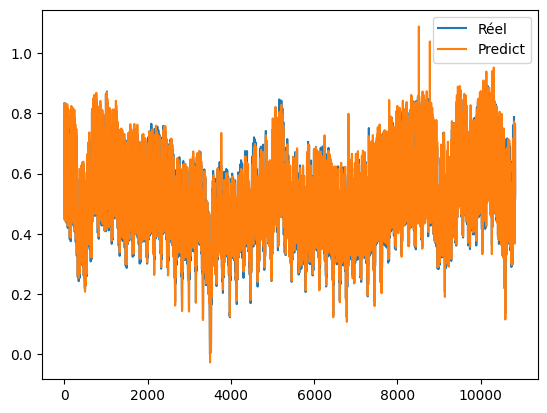

In [13]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
plt.plot(y_test, label="Réel")
plt.plot(y_pred, label="Predict")
plt.legend()
plt.show()